⚠️ Multi-frame segmentation for LUNG1-070
✅ Bbox: X=264, Y=299, W=38, H=36
📏 Cropped patch shape: (36, 38)


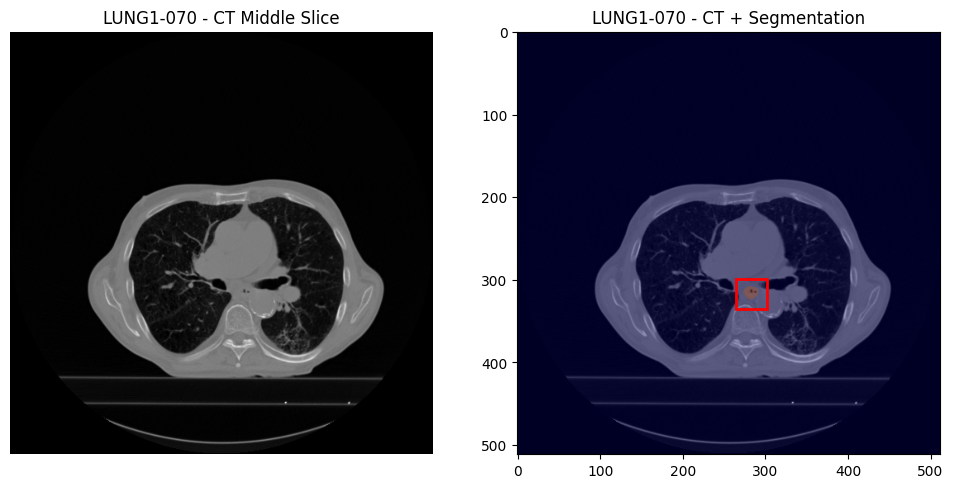

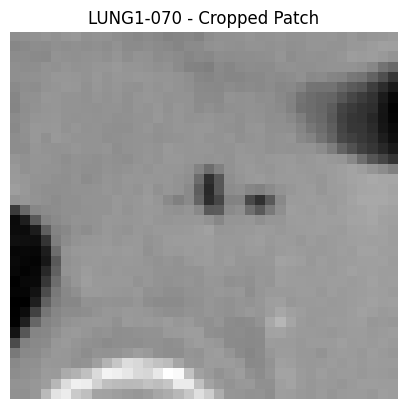

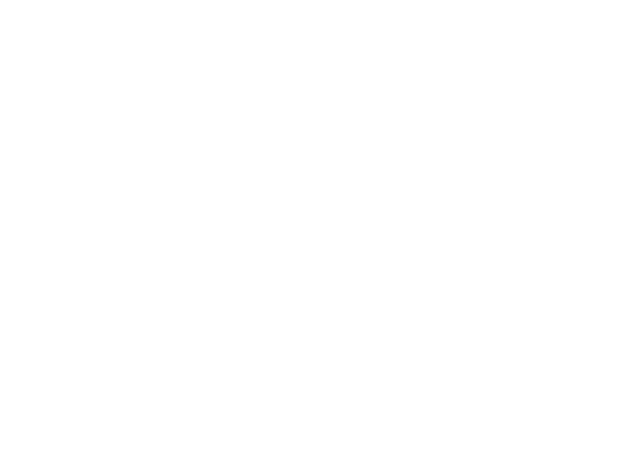

In [44]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Root folder
root_path = r"E:\NSCLC"  # Your path
patient_id = "LUNG1-070"
patient_path = os.path.join(root_path, patient_id)

# Initialize
ct_files = []
seg_files = []

# Recursively find all DICOMs
for root_dir, dirs, files in os.walk(patient_path):
    for file in files:
        if file.endswith(".dcm"):
            full_path = os.path.join(root_dir, file)
            if "Segmentation" in root_dir:
                seg_files.append(full_path)
            else:
                ct_files.append(full_path)

if not ct_files:
    print(f"❌ No CT files for {patient_id}")
else:
    # Sort CT and pick middle
    ct_files.sort()
    middle_index = len(ct_files) // 2
    ct_dcm = pydicom.dcmread(ct_files[middle_index])
    ct_image = ct_dcm.pixel_array

    # Plot original CT
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_image, cmap="gray")
    plt.title(f"{patient_id} - CT Middle Slice")
    plt.axis('off')

    # Process segmentation
    plt.subplot(1, 2, 2)
    plt.imshow(ct_image, cmap="gray")

    if seg_files:
        try:
            seg_dcm = pydicom.dcmread(seg_files[0])

            # Handle multi-frame
            if hasattr(seg_dcm, 'NumberOfFrames') and seg_dcm.NumberOfFrames > 1:
                print(f"⚠️ Multi-frame segmentation for {patient_id}")
                seg_data = seg_dcm.pixel_array[middle_index]
            else:
                seg_data = seg_dcm.pixel_array

            # Binary mask
            mask = (seg_data > 0).astype(np.uint8)

            # Find contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                x, y, w, h = cv2.boundingRect(largest_contour)

                # Enlarge bbox
                enlarge = 10
                x = max(x - enlarge, 0)
                y = max(y - enlarge, 0)
                w = min(w + 2*enlarge, ct_image.shape[1] - x)
                h = min(h + 2*enlarge, ct_image.shape[0] - y)

                print(f"✅ Bbox: X={x}, Y={y}, W={w}, H={h}")

                # Draw rectangle on plot
                rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
                plt.gca().add_patch(rect)

                # Overlay segmentation
                plt.imshow(seg_data, cmap="jet", alpha=0.3, vmin=0, vmax=1)
                plt.title(f"{patient_id} - CT + Segmentation")

                # 🛑 Now: crop from original CT
                cropped_ct = ct_image[y:y+h, x:x+w]
                print(f"📏 Cropped patch shape: {cropped_ct.shape}")

                # Show cropped image
                plt.figure(figsize=(5, 5))
                plt.imshow(cropped_ct, cmap='gray')
                plt.title(f"{patient_id} - Cropped Patch")
                plt.axis('off')
                plt.show()

            else:
                print(f"⚠️ No contours detected for {patient_id}")
        except Exception as e:
            print(f"❌ Error loading segmentation: {str(e)}")
    else:
        print(f"⚠️ No segmentation available for {patient_id}")

    plt.axis('off')
    plt.tight_layout()
    plt.show()


✅ Bounding Box on segmentation: x=264, y=299, w=38, h=36


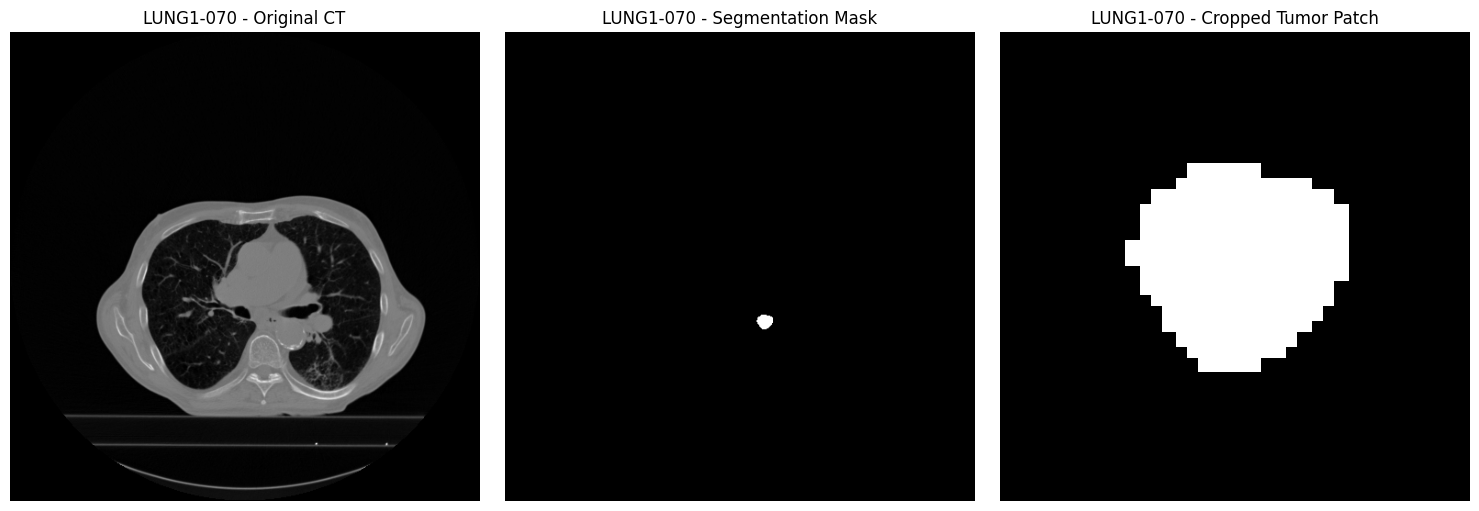

In [45]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Paths
root_path = r"E:\NSCLC"  # Your folder
patient_id = "LUNG1-070"
patient_path = os.path.join(root_path, patient_id)

# 2. Find files
ct_files = []
seg_files = []

for root_dir, dirs, files in os.walk(patient_path):
    for file in files:
        if file.endswith(".dcm"):
            full_path = os.path.join(root_dir, file)
            if "Segmentation" in root_dir:
                seg_files.append(full_path)
            else:
                ct_files.append(full_path)

# 3. Check
if not ct_files:
    raise Exception(f"❌ No CT files for {patient_id}")

if not seg_files:
    raise Exception(f"❌ No segmentation file for {patient_id}")

# 4. Load CT and Segmentation
ct_files.sort()
middle_index = len(ct_files) // 2
ct_dcm = pydicom.dcmread(ct_files[middle_index])
ct_image = ct_dcm.pixel_array

seg_dcm = pydicom.dcmread(seg_files[0])

# Handle multi-frame segmentation
if hasattr(seg_dcm, 'NumberOfFrames') and seg_dcm.NumberOfFrames > 1:
    seg_data = seg_dcm.pixel_array[middle_index]
else:
    seg_data = seg_dcm.pixel_array

# 5. Build binary mask
mask = (seg_data > 0).astype(np.uint8)

# 6. Find contours on mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not contours:
    raise Exception(f"⚠️ No contours detected for {patient_id}")

# 7. Get the biggest contour (tumor)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)

# Optional: enlarge bbox a bit
enlarge = 10
x = max(x - enlarge, 0)
y = max(y - enlarge, 0)
w = min(w + 2*enlarge, ct_image.shape[1] - x)
h = min(h + 2*enlarge, ct_image.shape[0] - y)

print(f"✅ Bounding Box on segmentation: x={x}, y={y}, w={w}, h={h}")

# 8. Now patch the segmentation mask!
cropped_mask = mask[y:y+h, x:x+w]

# 9. Optional preprocessing: resize patch (128x128) to feed into CNN
cropped_mask_resized = cv2.resize(cropped_mask, (128, 128), interpolation=cv2.INTER_NEAREST)

# 10. Show everything
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(ct_image, cmap='gray')
plt.title(f"{patient_id} - Original CT")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title(f"{patient_id} - Segmentation Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cropped_mask_resized, cmap='gray')
plt.title(f"{patient_id} - Cropped Tumor Patch")
plt.axis('off')

plt.tight_layout()
plt.show()


✅ Final patch shape (H, W, Channels): (128, 128, 2)


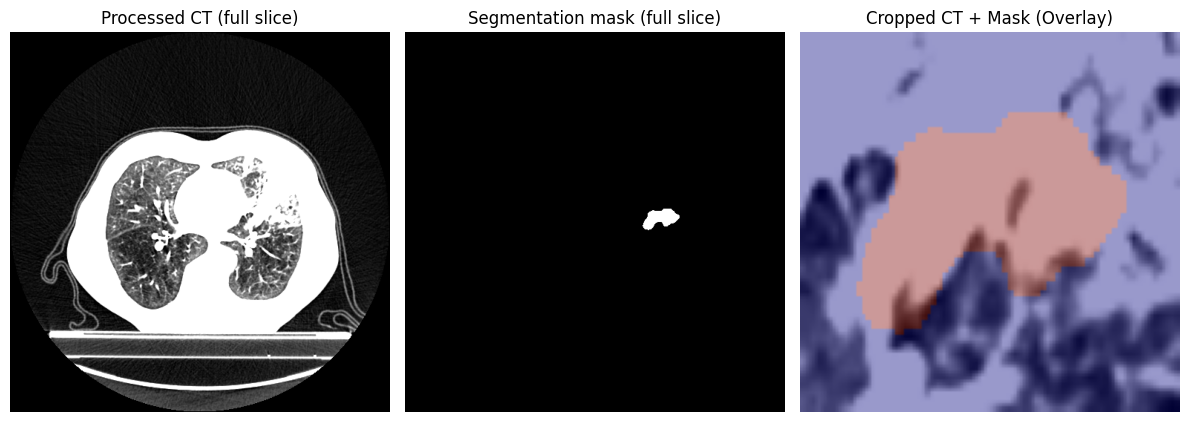

In [31]:
import os
import pydicom
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_ct_and_mask(patient_path):
    ct_files = []
    seg_files = []

    for root_dir, dirs, files in os.walk(patient_path):
        for file in files:
            if file.endswith(".dcm"):
                full_path = os.path.join(root_dir, file)
                if "Segmentation" in root_dir:
                    seg_files.append(full_path)
                else:
                    ct_files.append(full_path)

    if not ct_files:
        raise Exception(f"No CT files found for {patient_path}")
    if not seg_files:
        raise Exception(f"No segmentation files found for {patient_path}")

    ct_files.sort()
    middle_index = len(ct_files) // 2

    ct_dcm = pydicom.dcmread(ct_files[middle_index])
    seg_dcm = pydicom.dcmread(seg_files[0])

    ct_image = ct_dcm.pixel_array

    if hasattr(seg_dcm, 'NumberOfFrames') and seg_dcm.NumberOfFrames > 1:
        seg_image = seg_dcm.pixel_array[middle_index]
    else:
        seg_image = seg_dcm.pixel_array

    return ct_image, seg_image

def preprocess_ct(ct_image):
    """Window CT image to lung window and normalize"""
    ct_image = np.clip(ct_image, -1000, 400)
    ct_image = (ct_image + 1000) / 1400  # Scale to [0, 1]
    return ct_image

def get_bbox_from_mask(mask, enlarge=10):
    """Find bounding box and enlarge it a bit"""
    mask_bin = (mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None  # No nodule found

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Enlarge
    x = max(x - enlarge, 0)
    y = max(y - enlarge, 0)
    return x, y, w + 2 * enlarge, h + 2 * enlarge

def prepare_patch(ct_image, mask_image, bbox, size=(128, 128)):
    """Crop CT and mask according to bbox, resize and stack"""
    x, y, w, h = bbox
    ct_crop = ct_image[y:y+h, x:x+w]
    mask_crop = (mask_image[y:y+h, x:x+w] > 0).astype(np.uint8)

    # Resize
    ct_crop_resized = cv2.resize(ct_crop, size, interpolation=cv2.INTER_LINEAR)
    mask_crop_resized = cv2.resize(mask_crop, size, interpolation=cv2.INTER_NEAREST)

    # Stack into 2 channels
    final_patch = np.stack([ct_crop_resized, mask_crop_resized], axis=-1)

    return final_patch

# --- MAIN SCRIPT STARTS HERE ---

# Example patient
root_path = r"E:\NSCLC"
patient_id = "LUNG1-001"
patient_path = os.path.join(root_path, patient_id)

# 1. Load images
ct_image, seg_image = load_ct_and_mask(patient_path)

# 2. Preprocess CT
ct_image_processed = preprocess_ct(ct_image)

# 3. Get bbox from segmentation
bbox = get_bbox_from_mask(seg_image)

if bbox is None:
    print(f"⚠️ No tumor found in {patient_id}")
else:
    # 4. Prepare final 2-channel patch
    final_patch = prepare_patch(ct_image_processed, seg_image, bbox)

    print(f"✅ Final patch shape (H, W, Channels): {final_patch.shape}")  # (128, 128, 2)

    # 5. Visualize
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(ct_image_processed, cmap='gray')
    plt.title("Processed CT (full slice)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(seg_image, cmap='gray')
    plt.title("Segmentation mask (full slice)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(final_patch[:, :, 0], cmap='gray')
    plt.imshow(final_patch[:, :, 1], cmap='jet', alpha=0.4)
    plt.title("Cropped CT + Mask (Overlay)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 6. You can now save it if you want:
    # np.save(f"{patient_id}_patch.npy", final_patch)


In [47]:
import os
import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt

# -----------------------------
# CONFIGURATION
# -----------------------------

root_path = r"E:\NSCLC"  # DICOM folders
csv_path = r"E:\NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"  # CSV
output_dir = r"E:\NSCLC_dataset"  # Output save path

os.makedirs(output_dir, exist_ok=True)

# -----------------------------
# FUNCTIONS
# -----------------------------

def load_ct_and_mask(patient_path):
    ct_files, seg_files = [], []

    for root_dir, dirs, files in os.walk(patient_path):
        for file in files:
            if file.endswith(".dcm"):
                full_path = os.path.join(root_dir, file)
                if "Segmentation" in root_dir:
                    seg_files.append(full_path)
                else:
                    ct_files.append(full_path)

    if not ct_files or not seg_files:
        return None, None

    ct_files.sort()
    middle_index = len(ct_files) // 2

    ct_image = pydicom.dcmread(ct_files[middle_index]).pixel_array
    seg_dcm = pydicom.dcmread(seg_files[0])
    
    if hasattr(seg_dcm, 'NumberOfFrames') and seg_dcm.NumberOfFrames > 1:
        seg_image = seg_dcm.pixel_array[middle_index]
    else:
        seg_image = seg_dcm.pixel_array

    return ct_image, seg_image

def preprocess_ct(ct_image):
    ct_image = np.clip(ct_image, -1000, 400)
    ct_image = (ct_image + 1000) / 1400  # Normalize [0,1]
    return ct_image

def get_bbox(mask, enlarge=10):
    mask_bin = (mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    x = max(x - enlarge, 0)
    y = max(y - enlarge, 0)
    w += 2 * enlarge
    h += 2 * enlarge

    return x, y, w, h

def create_patch(ct_image, mask_image, bbox, size=(128,128)):
    x, y, w, h = bbox
    ct_crop = ct_image[y:y+h, x:x+w]
    mask_crop = (mask_image[y:y+h, x:x+w] > 0).astype(np.uint8)

    ct_crop_resized = cv2.resize(ct_crop, size, interpolation=cv2.INTER_LINEAR)
    mask_crop_resized = cv2.resize(mask_crop, size, interpolation=cv2.INTER_NEAREST)

    patch = np.stack([ct_crop_resized, mask_crop_resized], axis=-1)

    return patch

# -----------------------------
# MAIN LOOP
# -----------------------------

# Load CSV once
df = pd.read_csv(csv_path)
df = df.dropna(subset=["Overall.Stage"])

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Overall.Stage'] = le.fit_transform(df['Overall.Stage'])

print(f"✅ Classes: {list(le.classes_)}")

# Prepare save arrays
all_labels = []
all_patient_ids = []

for idx, row in df.iterrows():
    patient_id = row['PatientID']
    label = row['Overall.Stage']
    patient_folder = os.path.join(root_path, patient_id)

    if not os.path.exists(patient_folder):
        print(f"⚠️ Skipping {patient_id} (folder missing)")
        continue

    ct_img, seg_img = load_ct_and_mask(patient_folder)
    if ct_img is None or seg_img is None:
        print(f"⚠️ Skipping {patient_id} (missing CT/Segmentation)")
        continue

    bbox = get_bbox(seg_img)
    if bbox is None:
        print(f"⚠️ Skipping {patient_id} (no tumor found)")
        continue

    ct_img = preprocess_ct(ct_img)

    patch = create_patch(ct_img, seg_img, bbox)

    save_path = os.path.join(output_dir, f"{patient_id}.npy")
    np.save(save_path, patch)

    all_labels.append(label)
    all_patient_ids.append(patient_id)

    print(f"✅ Saved {patient_id} with label {label}")

# Save labels
np.save(os.path.join(output_dir, "labels.npy"), np.array(all_labels))
np.save(os.path.join(output_dir, "patients.npy"), np.array(all_patient_ids))

print("\n🎉 All done! Patches and labels saved!")


✅ Classes: ['I', 'II', 'IIIa', 'IIIb']
✅ Saved LUNG1-001 with label 3
✅ Saved LUNG1-002 with label 0
✅ Saved LUNG1-003 with label 3
✅ Saved LUNG1-004 with label 1
✅ Saved LUNG1-005 with label 3
✅ Saved LUNG1-006 with label 2
✅ Saved LUNG1-007 with label 2
✅ Saved LUNG1-008 with label 2
✅ Saved LUNG1-009 with label 2
✅ Saved LUNG1-010 with label 3
✅ Saved LUNG1-011 with label 3
✅ Saved LUNG1-012 with label 2
⚠️ Skipping LUNG1-013 (no tumor found)
✅ Saved LUNG1-014 with label 3
⚠️ Skipping LUNG1-015 (no tumor found)
✅ Saved LUNG1-016 with label 0
✅ Saved LUNG1-017 with label 3
✅ Saved LUNG1-018 with label 1
✅ Saved LUNG1-019 with label 0
✅ Saved LUNG1-020 with label 3
✅ Saved LUNG1-021 with label 3
✅ Saved LUNG1-022 with label 0
✅ Saved LUNG1-023 with label 2
✅ Saved LUNG1-024 with label 0
✅ Saved LUNG1-025 with label 3
✅ Saved LUNG1-026 with label 3
⚠️ Skipping LUNG1-027 (no tumor found)
✅ Saved LUNG1-028 with label 0
⚠️ Skipping LUNG1-029 (no tumor found)
✅ Saved LUNG1-030 with label 3

✅ Loaded 168 images.
✅ After cleaning: 166 samples
✅ After balancing: 400 samples
✅ Train: 320 | Val: 40 | Test: 40
✅ Everything saved in: E:\NSCLC_final_dataset


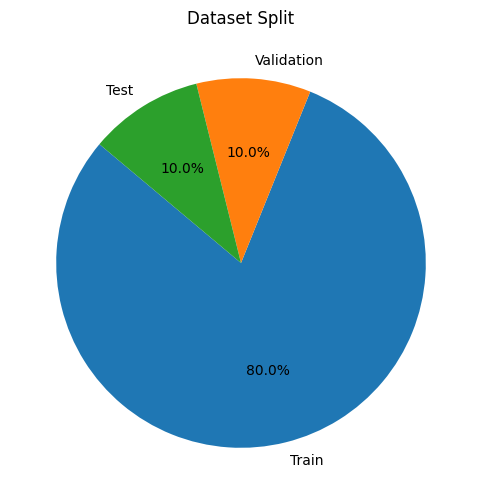

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_dataset"
csv_path = r"E:\NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"
save_path = r"E:\NSCLC_final_dataset"  # ➡️ Final save folder
os.makedirs(save_path, exist_ok=True)

# ------------------------
# 2. LOAD ORIGINAL DATA
# ------------------------

# Load labels
labels = np.load(os.path.join(dataset_path, 'labels.npy'))

# Load patches
X_images = []
patient_ids = []

for filename in os.listdir(dataset_path):
    if filename.endswith('.npy') and filename not in ['labels.npy', 'patients.npy']:
        path = os.path.join(dataset_path, filename)
        patch = np.load(path)
        X_images.append(patch)
        patient_ids.append(filename.replace('.npy', ''))

X_images = np.array(X_images)
y = labels

print(f"✅ Loaded {X_images.shape[0]} images.")

# ------------------------
# 3. LOAD CLINICAL FEATURES
# ------------------------

# Load clinical data
clinical_df = pd.read_csv(csv_path)

# Keep only patients available
clinical_df = clinical_df[clinical_df['PatientID'].isin(patient_ids)]
clinical_df = clinical_df.reset_index(drop=True)

# Features you want
features = ['age', 'clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage', 'Histology', 'gender']

# Encode categorical features
for col in ['clinical.T.Stage', 'Clinical.N.Stage', 'Clinical.M.Stage', 'Histology', 'gender']:
    clinical_df[col] = LabelEncoder().fit_transform(clinical_df[col].astype(str))

# Create clinical feature matrix
X_clinical = clinical_df[features].values

# Align clinical data to order of patches
aligned_clinical = np.zeros((len(patient_ids), X_clinical.shape[1]))

for i, pid in enumerate(patient_ids):
    idx = clinical_df.index[clinical_df['PatientID'] == pid].tolist()
    if idx:
        aligned_clinical[i] = X_clinical[idx[0]]
    else:
        aligned_clinical[i] = np.nan

# Filter out missing
valid_indices = ~np.isnan(aligned_clinical).any(axis=1)
X_images = X_images[valid_indices]
aligned_clinical = aligned_clinical[valid_indices]
y = y[valid_indices]
patient_ids = np.array(patient_ids)[valid_indices]

print(f"✅ After cleaning: {X_images.shape[0]} samples")

# Normalize clinical features
scaler = StandardScaler()
aligned_clinical = scaler.fit_transform(aligned_clinical)

# ------------------------
# 4. BALANCING (100 samples per class)
# ------------------------

X_img_balanced = []
X_clin_balanced = []
y_balanced = []
patients_balanced = []

for target_class in np.unique(y):
    indices = np.where(y == target_class)[0]
    
    if len(indices) == 0:
        continue
    
    repeats = 100 // len(indices)
    remainder = 100 % len(indices)
    
    full_indices = np.tile(indices, repeats)
    extra_indices = np.random.choice(indices, remainder, replace=True)
    
    final_indices = np.concatenate([full_indices, extra_indices])
    
    X_img_balanced.append(X_images[final_indices])
    X_clin_balanced.append(aligned_clinical[final_indices])
    y_balanced.append(np.full(100, target_class))
    patients_balanced.append(patient_ids[final_indices])

# Concatenate all
X_img_balanced = np.concatenate(X_img_balanced, axis=0)
X_clin_balanced = np.concatenate(X_clin_balanced, axis=0)
y_balanced = np.concatenate(y_balanced, axis=0)
patients_balanced = np.concatenate(patients_balanced, axis=0)

# Shuffle
perm = np.random.permutation(len(y_balanced))
X_img_balanced = X_img_balanced[perm]
X_clin_balanced = X_clin_balanced[perm]
y_balanced = y_balanced[perm]
patients_balanced = patients_balanced[perm]

print(f"✅ After balancing: {X_img_balanced.shape[0]} samples")

# ------------------------
# 5. SPLIT (80/10/10)
# ------------------------

# Split train vs temp
X_img_train, X_img_temp, X_clin_train, X_clin_temp, y_train, y_temp, patients_train, patients_temp = train_test_split(
    X_img_balanced, X_clin_balanced, y_balanced, patients_balanced,
    test_size=0.2, stratify=y_balanced, random_state=42
)

# Split val vs test
X_img_val, X_img_test, X_clin_val, X_clin_test, y_val, y_test, patients_val, patients_test = train_test_split(
    X_img_temp, X_clin_temp, y_temp, patients_temp,
    test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✅ Train: {X_img_train.shape[0]} | Val: {X_img_val.shape[0]} | Test: {X_img_test.shape[0]}")

# ------------------------
# 6. SAVE ALL
# ------------------------

np.save(os.path.join(save_path, 'X_train.npy'), X_img_train)
np.save(os.path.join(save_path, 'y_train.npy'), y_train)
np.save(os.path.join(save_path, 'clinical_train.npy'), X_clin_train)
np.save(os.path.join(save_path, 'patients_train.npy'), patients_train)

np.save(os.path.join(save_path, 'X_val.npy'), X_img_val)
np.save(os.path.join(save_path, 'y_val.npy'), y_val)
np.save(os.path.join(save_path, 'clinical_val.npy'), X_clin_val)
np.save(os.path.join(save_path, 'patients_val.npy'), patients_val)

np.save(os.path.join(save_path, 'X_test.npy'), X_img_test)
np.save(os.path.join(save_path, 'y_test.npy'), y_test)
np.save(os.path.join(save_path, 'clinical_test.npy'), X_clin_test)
np.save(os.path.join(save_path, 'patients_test.npy'), patients_test)

print("✅ Everything saved in:", save_path)

# ------------------------
# 7. (OPTIONAL) Pie Chart
# ------------------------

plt.figure(figsize=(6,6))
plt.pie(
    [len(y_train), len(y_val), len(y_test)],
    labels=["Train", "Validation", "Test"],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Dataset Split')
plt.show()


✅ Loaded data:
Train: (320, 128, 128, 2) images, (320, 6) clinical
Val: (40, 128, 128, 2) images, (40, 6) clinical
Test: (40, 128, 128, 2) images, (40, 6) clinical
✅ Class weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 128,  │        608 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_17… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │        448 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 64)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 192)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     24,704 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 4)         │        516 │ dropout_26[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,524 (466.89 KB)

 Trainable params: 119,076 (465.14 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step - accuracy: 0.1940 - loss: 1.4296 - val_accuracy: 0.2500 - val_loss: 1.3919
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 535ms/step - accuracy: 0.3123 - loss: 1.3585 - val_accuracy: 0.2500 - val_loss: 1.3762
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 547ms/step - accuracy: 0.3103 - loss: 1.3343 - val_accuracy: 0.2000 - val_loss: 1.3612
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 552ms/step - accuracy: 0.4174 - loss: 1.3055 - val_accuracy: 0.3000 - val_loss: 1.3472
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 536ms/step - accuracy: 0.3993 - loss: 1.2842 - val_accuracy: 0.3250 - val_loss: 1.3333
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 618ms/step - accuracy: 0.4340 - loss: 1.2868 - val_accuracy: 0.4500 - val_loss: 1.3211
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 618ms/step - accuracy: 0.4905 - loss: 1.2443 - val_accuracy: 0.4250 - val_loss: 1.3099
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.5136 - loss: 1.2202 - val_accuracy: 0.

✅ Final Validation Accuracy: 0.5500
✅ Model saved at: E:\NSCLC_final_dataset\nsclc_model.h5


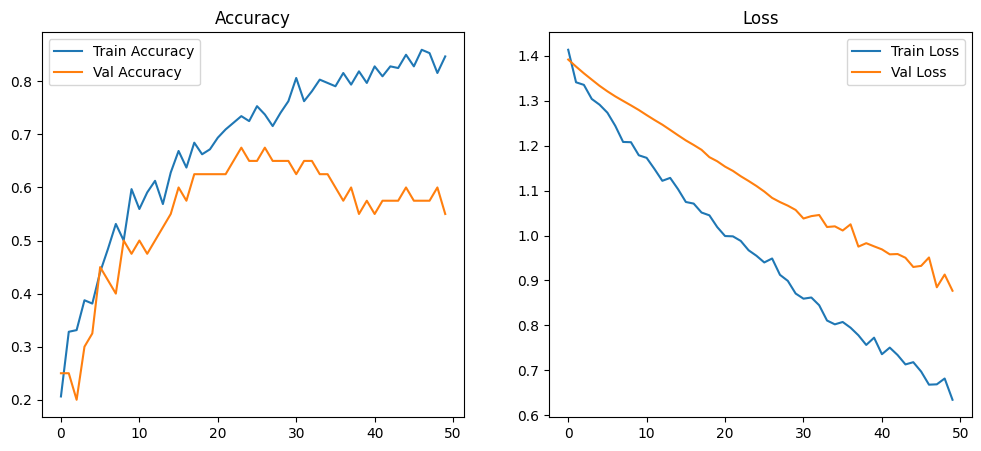

In [43]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your new final folder

# ------------------------
# 2. LOAD SPLIT DATA
# ------------------------

X_train = np.load(os.path.join(dataset_path, 'X_train.npy'))
X_val = np.load(os.path.join(dataset_path, 'X_val.npy'))
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))

y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

clinical_train = np.load(os.path.join(dataset_path, 'clinical_train.npy'))
clinical_val = np.load(os.path.join(dataset_path, 'clinical_val.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))

print(f"✅ Loaded data:")
print(f"Train: {X_train.shape} images, {clinical_train.shape} clinical")
print(f"Val: {X_val.shape} images, {clinical_val.shape} clinical")
print(f"Test: {X_test.shape} images, {clinical_test.shape} clinical")

# ------------------------
# 3. CLASS WEIGHTS
# ------------------------

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weights}")

# ------------------------
# 4. BUILD MODEL
# ------------------------

def build_multi_input_cnn(img_shape=(128,128,2), clinical_shape=(6,), num_classes=4):
    # Image input
    img_input = tf.keras.Input(shape=img_shape)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Clinical input
    clin_input = tf.keras.Input(shape=clinical_shape)
    y = tf.keras.layers.Dense(64, activation='relu')(clin_input)
    y = tf.keras.layers.Dropout(0.3)(y)

    # Merge
    combined = tf.keras.layers.concatenate([x, y])

    z = tf.keras.layers.Dense(128, activation='relu')(combined)
    z = tf.keras.layers.Dropout(0.3)(z)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

    model = tf.keras.Model(inputs=[img_input, clin_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_multi_input_cnn()

model.summary()

# ------------------------
# 5. TRAIN
# ------------------------

history = model.fit(
    [X_train, clinical_train], y_train,
    validation_data=([X_val, clinical_val], y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]
)

# ------------------------
# 6. EVALUATE
# ------------------------

loss, acc = model.evaluate([X_val, clinical_val], y_val)
print(f"✅ Final Validation Accuracy: {acc:.4f}")

# ------------------------
# 7. SAVE MODEL
# ------------------------

model_save_path = os.path.join(dataset_path, "nsclc_model.h5")
model.save(model_save_path)
print(f"✅ Model saved at: {model_save_path}")

# ------------------------
# 8. PLOT TRAINING CURVES
# ------------------------

def plot_training(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)



📊 Cancer Stage Distribution:
Stage 0: 42 patients
Stage 1: 13 patients
Stage 2: 38 patients
Stage 3: 75 patients


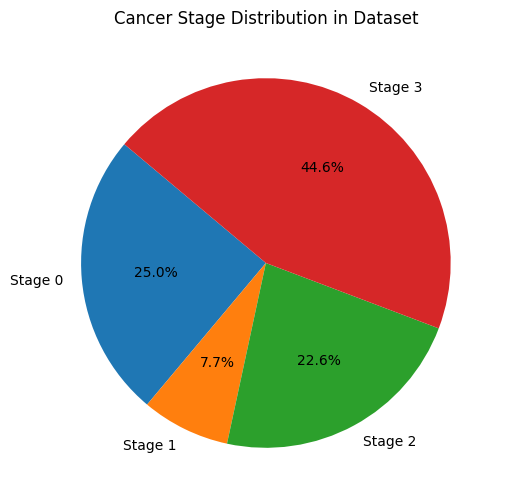

In [30]:
import numpy as np

# Your dataset folder
dataset_path = r"E:\NSCLC_dataset"

# Load labels
labels = np.load(os.path.join(dataset_path, 'labels.npy'))

# Count each stage
unique_stages, counts = np.unique(labels, return_counts=True)

# Display
print("\n📊 Cancer Stage Distribution:")
for stage, count in zip(unique_stages, counts):
    print(f"Stage {stage}: {count} patients")

# Optional pie chart
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.pie(counts, labels=[f"Stage {s}" for s in unique_stages], autopct='%1.1f%%', startangle=140)
plt.title('Cancer Stage Distribution in Dataset')
plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_dataset"
save_path = r"E:\NSCLC_final_dataset"  # ➡️ Créer ce dossier
os.makedirs(save_path, exist_ok=True)

# ------------------------
# 2. LOAD ORIGINAL DATA
# ------------------------

# Load labels
labels = np.load(os.path.join(dataset_path, 'labels.npy'))

# Load patches
X_images = []
patient_ids = []

for filename in os.listdir(dataset_path):
    if filename.endswith('.npy') and filename not in ['labels.npy', 'patients.npy']:
        path = os.path.join(dataset_path, filename)
        patch = np.load(path)
        X_images.append(patch)
        patient_ids.append(filename.replace('.npy', ''))

X_images = np.array(X_images)
y = labels

print(f"✅ Loaded {X_images.shape[0]} images.")

# ------------------------
# 3. BALANCING (100 samples per class)
# ------------------------

X_balanced = []
y_balanced = []
patient_ids_balanced = []

for target_class in np.unique(y):
    indices = np.where(y == target_class)[0]
    
    if len(indices) == 0:
        continue

    repeats = 100 // len(indices)
    remainder = 100 % len(indices)
    
    full_indices = np.tile(indices, repeats)
    extra_indices = np.random.choice(indices, remainder, replace=True)
    
    final_indices = np.concatenate([full_indices, extra_indices])
    
    X_balanced.append(X_images[final_indices])
    y_balanced.append(np.full(100, target_class))
    patient_ids_balanced.append(np.array(patient_ids)[final_indices])

# Concaténer tout
X_balanced = np.concatenate(X_balanced, axis=0)
y_balanced = np.concatenate(y_balanced, axis=0)
patient_ids_balanced = np.concatenate(patient_ids_balanced, axis=0)

print(f"✅ After balancing: {X_balanced.shape[0]} images.")

# Shuffle
perm = np.random.permutation(len(y_balanced))
X_balanced = X_balanced[perm]
y_balanced = y_balanced[perm]
patient_ids_balanced = patient_ids_balanced[perm]

# ------------------------
# 4. SPLIT DATA (80% train / 10% val / 10% test)
# ------------------------

# First split: train vs (val+test)
X_train, X_temp, y_train, y_temp, patients_train, patients_temp = train_test_split(
    X_balanced, y_balanced, patient_ids_balanced,
    test_size=0.2, stratify=y_balanced, random_state=42
)

# Second split: validation vs test (50/50 of temp set)
X_val, X_test, y_val, y_test, patients_val, patients_test = train_test_split(
    X_temp, y_temp, patients_temp,
    test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✅ Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

# ------------------------
# 5. SAVE NEW DATA
# ------------------------

np.save(os.path.join(save_path, 'X_train.npy'), X_train)
np.save(os.path.join(save_path, 'y_train.npy'), y_train)
np.save(os.path.join(save_path, 'patients_train.npy'), patients_train)

np.save(os.path.join(save_path, 'X_val.npy'), X_val)
np.save(os.path.join(save_path, 'y_val.npy'), y_val)
np.save(os.path.join(save_path, 'patients_val.npy'), patients_val)

np.save(os.path.join(save_path, 'X_test.npy'), X_test)
np.save(os.path.join(save_path, 'y_test.npy'), y_test)
np.save(os.path.join(save_path, 'patients_test.npy'), patients_test)

print("✅ Datasets saved in:", save_path)

# ------------------------
# 6. OPTIONAL: PIE CHART
# ------------------------

plt.figure(figsize=(6,6))
plt.pie(
    [len(y_train), len(y_val), len(y_test)],
    labels=["Train", "Validation", "Test"],
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Dataset Split')
plt.show()


✅ Loaded data shapes:
Train: (320, 128, 128, 2), Clinical: (320, 6)
Val: (40, 128, 128, 2), Clinical: (40, 6)
Test: (40, 128, 128, 2), Clinical: (40, 6)
✅ Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │        608 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_18… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_19… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 64)        │        448 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 64)        │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 192)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │     24,704 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 128)       │          0 │ dense_35[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 4)         │        516 │ dropout_28[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,524 (466.89 KB)

 Trainable params: 119,076 (465.14 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.2392 - loss: 1.4602 - val_accuracy: 0.3750 - val_loss: 1.3184
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 569ms/step - accuracy: 0.3775 - loss: 1.2936 - val_accuracy: 0.7250 - val_loss: 1.2359
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 549ms/step - accuracy: 0.5058 - loss: 1.1921 - val_accuracy: 0.7250 - val_loss: 1.1720
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 546ms/step - accuracy: 0.5991 - loss: 1.1084 - val_accuracy: 0.7000 - val_loss: 1.1073
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 565ms/step - accuracy: 0.6267 - loss: 1.0449 - val_accuracy: 0.7000 - val_loss: 1.0432
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 559ms/step - accuracy: 0.6647 - loss: 0.9893 - val_accuracy: 0.7250 - val_loss: 0.9808
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 560ms/step - accuracy: 0.7248 - loss: 0.8980 - val_accuracy: 0.7250 - val_loss: 0.9196
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.7472 - loss: 0.8204 - val_accuracy: 0.

✅ Final Validation Accuracy: 0.8500
✅ Model saved to E:\NSCLC_final_dataset\nsclc_model_final.h5


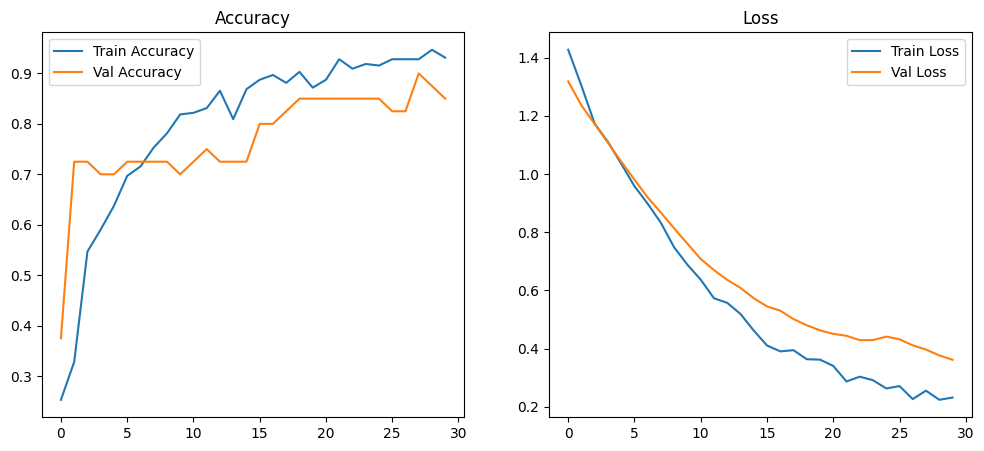

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# ------------------------5
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your final dataset

# ------------------------
# 2. LOAD SPLIT DATA
# ------------------------

X_train = np.load(os.path.join(dataset_path, 'X_train.npy'))
X_val = np.load(os.path.join(dataset_path, 'X_val.npy'))
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))

y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

clinical_train = np.load(os.path.join(dataset_path, 'clinical_train.npy'))
clinical_val = np.load(os.path.join(dataset_path, 'clinical_val.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))

print(f"✅ Loaded data shapes:")
print(f"Train: {X_train.shape}, Clinical: {clinical_train.shape}")
print(f"Val: {X_val.shape}, Clinical: {clinical_val.shape}")
print(f"Test: {X_test.shape}, Clinical: {clinical_test.shape}")

# ------------------------
# 3. CLASS WEIGHTS
# ------------------------

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: {class_weights}")

# ------------------------
# 4. BUILD MODEL
# ------------------------

def build_multi_input_cnn(img_shape=(128,128,2), clinical_shape=(6,), num_classes=4):
    img_input = tf.keras.Input(shape=img_shape)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    clin_input = tf.keras.Input(shape=clinical_shape)
    y = tf.keras.layers.Dense(64, activation='relu')(clin_input)
    y = tf.keras.layers.Dropout(0.3)(y)

    combined = tf.keras.layers.concatenate([x, y])

    z = tf.keras.layers.Dense(128, activation='relu')(combined)
    z = tf.keras.layers.Dropout(0.3)(z)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

    model = tf.keras.Model(inputs=[img_input, clin_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),  # 🔥 Slightly bigger LR (0.0005)
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_multi_input_cnn()
model.summary()

# ------------------------
# 5. TRAIN
# ------------------------

history = model.fit(
    [X_train, clinical_train], y_train,
    validation_data=([X_val, clinical_val], y_val),
    epochs=30,  # 🔥 Reduced epochs
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # 🔥 patience = 5
    ]
)

# ------------------------
# 6. EVALUATE
# ------------------------

loss, acc = model.evaluate([X_val, clinical_val], y_val)
print(f"✅ Final Validation Accuracy: {acc:.4f}")

# ------------------------
# 7. SAVE MODEL
# ------------------------

model_save_path = os.path.join(dataset_path, "nsclc_model_final.h5")
model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

# ------------------------
# 8. PLOT TRAINING CURVES
# ------------------------

def plot_training(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)


✅ Model loaded!
✅ Loaded test set: (40, 128, 128, 2) images and (40, 6) clinical features
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

🎯 Prediction Results:
True Cancer Stage: 3
Predicted Cancer Stage: 3
Prediction Probabilities: [1.0330677e-04 7.8943362e-03 3.1419942e-01 6.7780292e-01]


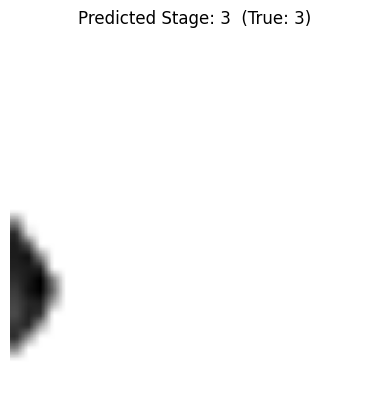

In [52]:
import os
import numpy as np
import tensorflow as tf

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your dataset
model_path = os.path.join(dataset_path, "nsclc_model_final.h5")  # Your saved model

# ------------------------
# 2. LOAD MODEL
# ------------------------

model = tf.keras.models.load_model(model_path)
print("✅ Model loaded!")

# ------------------------
# 3. LOAD TEST DATA
# ------------------------

X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

print(f"✅ Loaded test set: {X_test.shape} images and {clinical_test.shape} clinical features")

# ------------------------
# 4. SELECT ONE RANDOM TEST SAMPLE
# ------------------------

# Pick a random test sample
random_idx = np.random.randint(0, len(X_test))
sample_img = X_test[random_idx]
sample_clinical = clinical_test[random_idx]
true_label = y_test[random_idx]

# Expand dims to match model input
sample_img = np.expand_dims(sample_img, axis=0)         # (1, 128, 128, 2)
sample_clinical = np.expand_dims(sample_clinical, axis=0)  # (1, 6)

# ------------------------
# 5. PREDICT
# ------------------------

prediction = model.predict([sample_img, sample_clinical])
predicted_class = np.argmax(prediction)

print("\n🎯 Prediction Results:")
print(f"True Cancer Stage: {true_label}")
print(f"Predicted Cancer Stage: {predicted_class}")
print(f"Prediction Probabilities: {prediction.flatten()}")

# ------------------------
# 6. OPTIONAL: Show the image
# ------------------------

import matplotlib.pyplot as plt

plt.imshow(sample_img[0, :, :, 0], cmap='gray')
plt.title(f"Predicted Stage: {predicted_class}  (True: {true_label})")
plt.axis('off')
plt.show()


✅ Loaded data shapes:
Train: (320, 128, 128, 2), Clinical: (320, 6)
Val: (40, 128, 128, 2), Clinical: (40, 6)
Test: (40, 128, 128, 2), Clinical: (40, 6)
✅ Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │          9 │ input_layer_19[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_5          │ (None, 224, 224,  │          0 │ conv2d_22[0][0]   │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ resizing_5[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │        224 │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 1312)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │    168,064 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 4)         │        516 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,088,125 (23.22 MB)

 Trainable params: 168,813 (659.43 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 765ms/step - accuracy: 0.2373 - loss: 1.4740 - val_accuracy: 0.3500 - val_loss: 1.3171
Epoch 2/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 624ms/step - accuracy: 0.3881 - loss: 1.3374 - val_accuracy: 0.5000 - val_loss: 1.2888
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 618ms/step - accuracy: 0.3568 - loss: 1.3398 - val_accuracy: 0.7250 - val_loss: 1.2451
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 620ms/step - accuracy: 0.4172 - loss: 1.2846 - val_accuracy: 0.5750 - val_loss: 1.2117
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 633ms/step - accuracy: 0.3944 - loss: 1.2272 - val_accuracy: 0.6500 - val_loss: 1.1669
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 631ms/step - accuracy: 0.4573 - loss: 1.2049 - val_accuracy: 0.6250 - val_loss: 1.1278
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 650ms/step - accuracy: 0.4987 - loss: 1.1503 - val_accuracy: 0.8250 - val_loss: 1.0852
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 655ms/step - accuracy: 0.5318 - loss: 1.1152 - val_accu

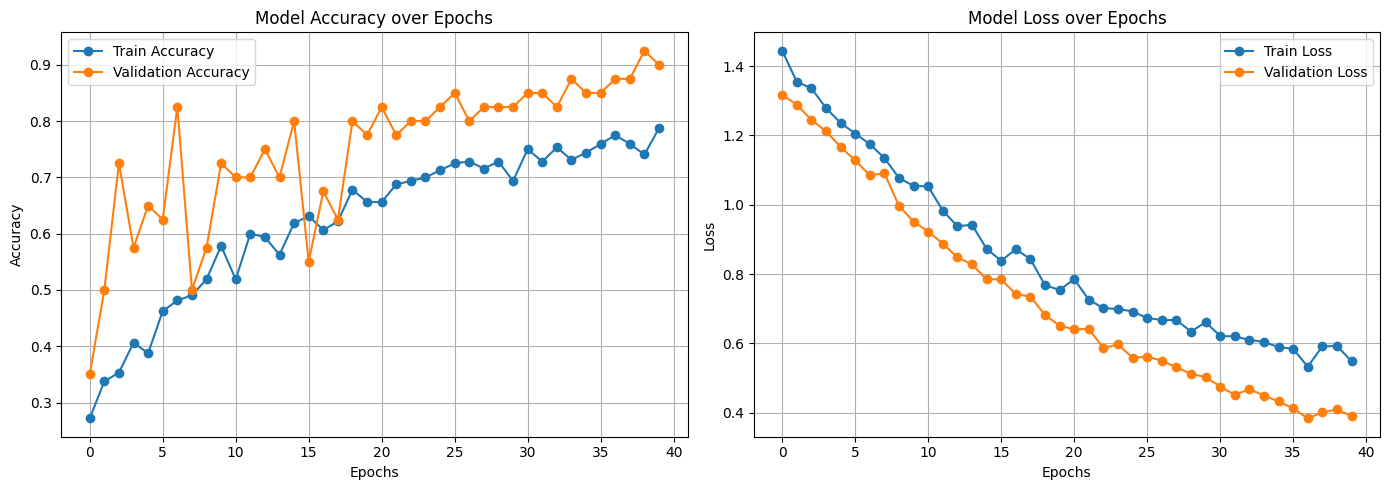

✅ Model saved to E:\NSCLC_final_dataset\nsclc_efficientnetv2b0_model_final.keras


In [22]:
# 📦 Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetV2B0

# 📂 Load Dataset
dataset_path = r"E:\NSCLC_final_dataset"  # Your dataset path

X_train = np.load(os.path.join(dataset_path, 'X_train.npy'))
X_val = np.load(os.path.join(dataset_path, 'X_val.npy'))
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))

y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

clinical_train = np.load(os.path.join(dataset_path, 'clinical_train.npy'))
clinical_val = np.load(os.path.join(dataset_path, 'clinical_val.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))

print(f"✅ Loaded data shapes:")
print(f"Train: {X_train.shape}, Clinical: {clinical_train.shape}")
print(f"Val: {X_val.shape}, Clinical: {clinical_val.shape}")
print(f"Test: {X_test.shape}, Clinical: {clinical_test.shape}")

# ⚖️ Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: {class_weights}")

# 🏗️ Build Model
def build_transfer_multi_input(img_shape=(128,128,2), clinical_shape=(6,), num_classes=4):
    # Image Branch
    img_input = tf.keras.Input(shape=img_shape)

    # Expand to 3 channels
    img = tf.keras.layers.Conv2D(3, (1,1), padding='same')(img_input)

    # Resize to 224x224
    img = tf.keras.layers.Resizing(224, 224)(img)

    # EfficientNetV2B0 BASE
    base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base_model.trainable = False  # Freeze

    x = base_model(img)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Clinical Branch
    clin_input = tf.keras.Input(shape=clinical_shape)
    y = tf.keras.layers.Dense(32, activation='relu')(clin_input)
    y = tf.keras.layers.Dropout(0.4)(y)

    # Fusion
    combined = tf.keras.layers.concatenate([x, y])

    # Dense Head
    z = tf.keras.layers.Dense(128, activation='relu')(combined)
    z = tf.keras.layers.Dropout(0.5)(z)

    output = tf.keras.layers.Dense(num_classes, activation='softmax')(z)

    model = tf.keras.Model(inputs=[img_input, clin_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_transfer_multi_input()
model.summary()

# 🏋️ Train Model
history = model.fit(
    [X_train, clinical_train], y_train,
    validation_data=([X_val, clinical_val], y_val),
    epochs=40,
    batch_size=16,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)

# 📈 Plot Training Curves
def plot_training(history):
    fig, axs = plt.subplots(1, 2, figsize=(14,5))

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    axs[0].set_title('Model Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    axs[1].set_title('Model Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training(history)
# 💾 SAVE MODEL
model_save_path = os.path.join(dataset_path, "nsclc_efficientnetv2b0_model_final.keras")
model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")


✅ Model loaded!
✅ Loaded test set: (40, 128, 128, 2) images and (40, 6) clinical features
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🎯 Prediction Results:
True Cancer Stage: 1
Predicted Cancer Stage: 1
Prediction Probabilities: [0.22547047 0.73196477 0.02867585 0.01388895]


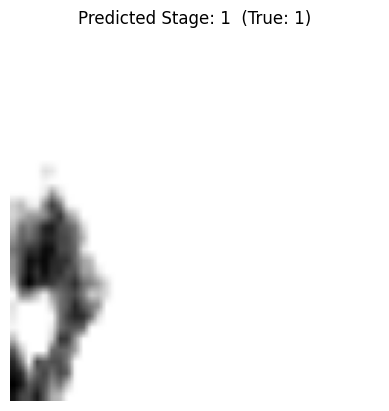

In [24]:
import os
import numpy as np
import tensorflow as tf

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your dataset
model_path = os.path.join(dataset_path, "nsclc_efficientnetv2b0_model_final.keras")  # Your saved model

# ------------------------
# 2. LOAD MODEL
# ------------------------

model = tf.keras.models.load_model(model_path)
print("✅ Model loaded!")

# ------------------------
# 3. LOAD TEST DATA
# ------------------------

X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

print(f"✅ Loaded test set: {X_test.shape} images and {clinical_test.shape} clinical features")

# ------------------------
# 4. SELECT ONE RANDOM TEST SAMPLE
# ------------------------

# Pick a random test sample
random_idx = np.random.randint(0, len(X_test))
sample_img = X_test[random_idx]
sample_clinical = clinical_test[random_idx]
true_label = y_test[random_idx]

# Expand dims to match model input
sample_img = np.expand_dims(sample_img, axis=0)         # (1, 128, 128, 2)
sample_clinical = np.expand_dims(sample_clinical, axis=0)  # (1, 6)

# ------------------------
# 5. PREDICT
# ------------------------

prediction = model.predict([sample_img, sample_clinical])
predicted_class = np.argmax(prediction)

print("\n🎯 Prediction Results:")
print(f"True Cancer Stage: {true_label}")
print(f"Predicted Cancer Stage: {predicted_class}")
print(f"Prediction Probabilities: {prediction.flatten()}")

# ------------------------
# 6. OPTIONAL: Show the image
# ------------------------

import matplotlib.pyplot as plt

plt.imshow(sample_img[0, :, :, 0], cmap='gray')
plt.title(f"Predicted Stage: {predicted_class}  (True: {true_label})")
plt.axis('off')
plt.show()


✅ Loaded data shapes:
Train: (320, 128, 128, 2), Clinical: (320, 6)
Val: (40, 128, 128, 2), Clinical: (40, 6)
Test: (40, 128, 128, 2), Clinical: (40, 6)
✅ Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      1,216 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │        448 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │ 33,554,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 576)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 34,774,852 (132.66 MB)

 Trainable params: 34,774,724 (132.66 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2873 - loss: 1.5455 - val_accuracy: 0.2750 - val_loss: 1.3666
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.3090 - loss: 1.4719 - val_accuracy: 0.2750 - val_loss: 1.3352
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.3834 - loss: 1.4204 - val_accuracy: 0.3000 - val_loss: 1.3152
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3645 - loss: 1.3466 - val_accuracy: 0.3000 - val_loss: 1.3062
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5243 - loss: 1.1621 - val_accuracy: 0.4000 - val_loss: 1.2769
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.4187 - loss: 1.2455 - val_accuracy: 0.3500 - val_loss: 1.2681
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5249 - loss: 1.1114 - val_accuracy: 0.5500 - val_loss: 1.2238
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5065 - loss: 1.0964 - val_accuracy: 0.6000 - val_loss:

✅ Final Validation Accuracy: 0.8000
✅ Model saved to E:\NSCLC_final_dataset\nsclc_vgg_model_final.h5


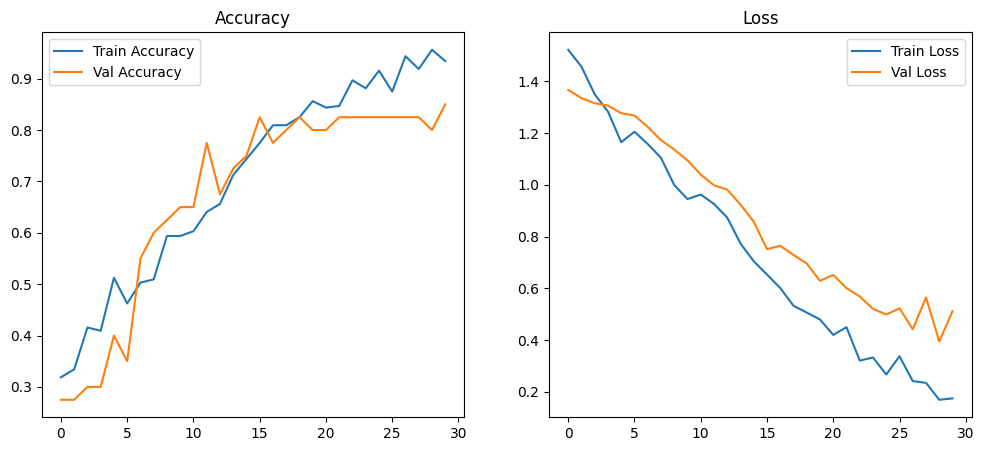

In [4]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your final dataset

# ------------------------
# 2. LOAD SPLIT DATA
# ------------------------

X_train = np.load(os.path.join(dataset_path, 'X_train.npy'))
X_val = np.load(os.path.join(dataset_path, 'X_val.npy'))
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))

y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

clinical_train = np.load(os.path.join(dataset_path, 'clinical_train.npy'))
clinical_val = np.load(os.path.join(dataset_path, 'clinical_val.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))

print(f"✅ Loaded data shapes:")
print(f"Train: {X_train.shape}, Clinical: {clinical_train.shape}")
print(f"Val: {X_val.shape}, Clinical: {clinical_val.shape}")
print(f"Test: {X_test.shape}, Clinical: {clinical_test.shape}")

# ------------------------
# 3. CLASS WEIGHTS
# ------------------------

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: {class_weights}")

# ------------------------
# 4. BUILD MODEL (VGG Style + Clinical Data)
# ------------------------

def build_vgg_multi_input(img_shape=(128,128,2), clinical_shape=(6,), num_classes=4):
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, concatenate

    # VGG Style Block
    img_input = Input(shape=img_shape)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Clinical branch
    clin_input = Input(shape=clinical_shape)
    y = Dense(64, activation='relu')(clin_input)
    y = BatchNormalization()(y)
    y = Dropout(0.4)(y)

    # Merge
    combined = concatenate([x, y])

    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation='softmax')(z)

    model = tf.keras.Model(inputs=[img_input, clin_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # 🔥 Lower learning rate for stability
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_vgg_multi_input()
model.summary()

# ------------------------
# 5. TRAIN
# ------------------------

history = model.fit(
    [X_train, clinical_train], y_train,
    validation_data=([X_val, clinical_val], y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    ]
)

# ------------------------
# 6. EVALUATE
# ------------------------

loss, acc = model.evaluate([X_val, clinical_val], y_val)
print(f"✅ Final Validation Accuracy: {acc:.4f}")

# ------------------------
# 7. SAVE MODEL
# ------------------------

model_save_path = os.path.join(dataset_path, "nsclc_vgg_model_final.h5")
model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

# ------------------------
# 8. PLOT TRAINING CURVES
# ------------------------

def plot_training(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)


✅ Model loaded!
✅ Loaded test set: (40, 128, 128, 2) images and (40, 6) clinical features
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step

🎯 Prediction Results:
True Cancer Stage: 0
Predicted Cancer Stage: 0
Prediction Probabilities: [8.7015533e-01 7.3801666e-03 7.8121590e-04 1.2168329e-01]


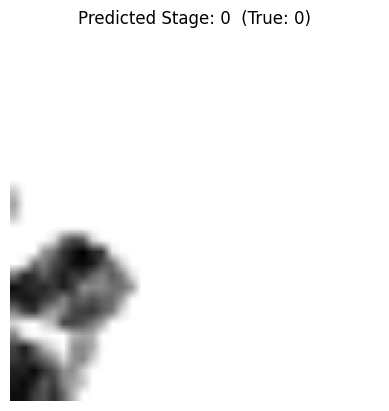

In [11]:
import os
import numpy as np
import tensorflow as tf

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your dataset
model_path = os.path.join(dataset_path, "nsclc_vgg_model_final.h5")  # Your saved model

# ------------------------
# 2. LOAD MODEL
# ------------------------

model = tf.keras.models.load_model(model_path)
print("✅ Model loaded!")

# ------------------------
# 3. LOAD TEST DATA
# ------------------------

X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

print(f"✅ Loaded test set: {X_test.shape} images and {clinical_test.shape} clinical features")

# ------------------------
# 4. SELECT ONE RANDOM TEST SAMPLE
# ------------------------

# Pick a random test sample
random_idx = np.random.randint(0, len(X_test))
sample_img = X_test[random_idx]
sample_clinical = clinical_test[random_idx]
true_label = y_test[random_idx]

# Expand dims to match model input
sample_img = np.expand_dims(sample_img, axis=0)         # (1, 128, 128, 2)
sample_clinical = np.expand_dims(sample_clinical, axis=0)  # (1, 6)

# ------------------------
# 5. PREDICT
# ------------------------

prediction = model.predict([sample_img, sample_clinical])
predicted_class = np.argmax(prediction)

print("\n🎯 Prediction Results:")
print(f"True Cancer Stage: {true_label}")
print(f"Predicted Cancer Stage: {predicted_class}")
print(f"Prediction Probabilities: {prediction.flatten()}")

# ------------------------
# 6. OPTIONAL: Show the image
# ------------------------

import matplotlib.pyplot as plt

plt.imshow(sample_img[0, :, :, 0], cmap='gray')
plt.title(f"Predicted Stage: {predicted_class}  (True: {true_label})")
plt.axis('off')
plt.show()


✅ Loaded data shapes:
Train: (320, 128, 128, 2), Clinical: (320, 6)
Val: (40, 128, 128, 2), Clinical: (40, 6)
Test: (40, 128, 128, 2), Clinical: (40, 6)
✅ Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │          9 │ input_layer_10[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_2          │ (None, 224, 224,  │          0 │ conv2d_19[0][0]   │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ resizing_2[0][0]  │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │        448 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_11[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 320)       │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     41,088 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 4)         │        516 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,419,824 (16.86 MB)

 Trainable params: 370,125 (1.41 MB)

 Non-trainable params: 4,049,699 (15.45 MB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.2848 - loss: 1.6451 - val_accuracy: 0.2500 - val_loss: 1.3677
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3175 - loss: 1.4663 - val_accuracy: 0.2750 - val_loss: 1.3379
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.3414 - loss: 1.4850 - val_accuracy: 0.2500 - val_loss: 1.3142
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4353 - loss: 1.2867 - val_accuracy: 0.3750 - val_loss: 1.2788
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4092 - loss: 1.2538 - val_accuracy: 0.6500 - val_loss: 1.2494
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.4442 - loss: 1.2086 - val_accuracy: 0.6250 - val_loss: 1.2222
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4972 - loss: 1.1349 - val_accuracy: 0.6500 - val_loss: 1.2004
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4982 - loss: 1.1866 - val_accuracy: 0.6500 - val_loss:

✅ Final Validation Accuracy: 0.7000
✅ Model saved to E:\NSCLC_final_dataset\nsclc_efficientnet_model_final.h5


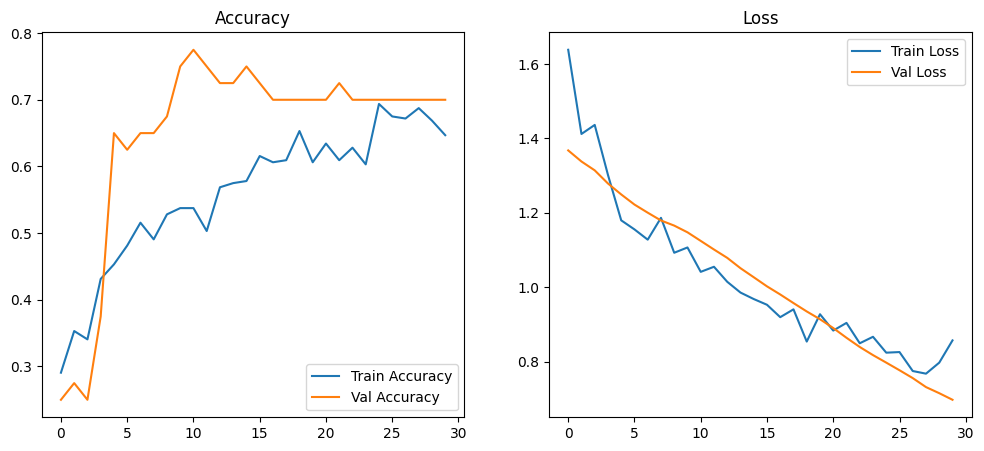

In [7]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your final dataset

# ------------------------
# 2. LOAD SPLIT DATA
# ------------------------

X_train = np.load(os.path.join(dataset_path, 'X_train.npy'))
X_val = np.load(os.path.join(dataset_path, 'X_val.npy'))
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))

y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

clinical_train = np.load(os.path.join(dataset_path, 'clinical_train.npy'))
clinical_val = np.load(os.path.join(dataset_path, 'clinical_val.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))

print(f"✅ Loaded data shapes:")
print(f"Train: {X_train.shape}, Clinical: {clinical_train.shape}")
print(f"Val: {X_val.shape}, Clinical: {clinical_val.shape}")
print(f"Test: {X_test.shape}, Clinical: {clinical_test.shape}")

# ------------------------
# 3. CLASS WEIGHTS
# ------------------------

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: {class_weights}")

# ------------------------
# 4. BUILD MODEL (EfficientNetB0 + Clinical)
# ------------------------

def build_efficientnet_multi_input(img_shape=(128,128,2), clinical_shape=(6,), num_classes=4):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, BatchNormalization, Conv2D, Resizing

    img_input = Input(shape=img_shape)

    # Convert (128,128,2) -> (128,128,3)
    if img_shape[-1] == 2:
        x = Conv2D(3, (1,1), padding='same')(img_input)
    else:
        x = img_input

    # Resize manually
    x = Resizing(224, 224)(x)

    # Now pass through EfficientNet
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base_model.trainable = False

    features = base_model(x)
    features = GlobalAveragePooling2D()(features)
    features = Dense(256, activation='relu')(features)
    features = Dropout(0.4)(features)

    # Clinical branch
    clin_input = Input(shape=clinical_shape)
    clinical_features = Dense(64, activation='relu')(clin_input)
    clinical_features = BatchNormalization()(clinical_features)
    clinical_features = Dropout(0.4)(clinical_features)

    # Merge
    combined = concatenate([features, clinical_features])

    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation='softmax')(z)

    model = tf.keras.Model(inputs=[img_input, clin_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_efficientnet_multi_input()
model.summary()

# ------------------------
# 5. TRAIN
# ------------------------

history = model.fit(
    [X_train, clinical_train], y_train,
    validation_data=([X_val, clinical_val], y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    ]
)

# ------------------------
# 6. EVALUATE
# ------------------------

loss, acc = model.evaluate([X_val, clinical_val], y_val)
print(f"✅ Final Validation Accuracy: {acc:.4f}")

# ------------------------
# 7. SAVE MODEL
# ------------------------

model_save_path = os.path.join(dataset_path, "nsclc_efficientnet_model_final.h5")
model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

# ------------------------
# 8. PLOT TRAINING CURVES
# ------------------------

def plot_training(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_training(history)


✅ Model loaded!
✅ Loaded test set: (40, 128, 128, 2) images and (40, 6) clinical features
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🎯 Prediction Results:
True Cancer Stage: 0
Predicted Cancer Stage: 0
Prediction Probabilities: [0.62265676 0.18992075 0.11543177 0.07199068]


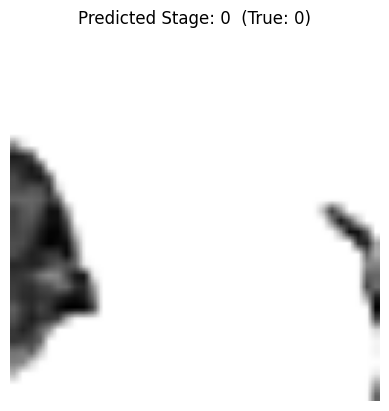

In [12]:
import os
import numpy as np
import tensorflow as tf

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your dataset
model_path = os.path.join(dataset_path, "nsclc_efficientnet_model_final.h5")  # Your saved model

# ------------------------
# 2. LOAD MODEL
# ------------------------

model = tf.keras.models.load_model(model_path)
print("✅ Model loaded!")

# ------------------------
# 3. LOAD TEST DATA
# ------------------------

X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

print(f"✅ Loaded test set: {X_test.shape} images and {clinical_test.shape} clinical features")

# ------------------------
# 4. SELECT ONE RANDOM TEST SAMPLE
# ------------------------

# Pick a random test sample
random_idx = np.random.randint(0, len(X_test))
sample_img = X_test[random_idx]
sample_clinical = clinical_test[random_idx]
true_label = y_test[random_idx]

# Expand dims to match model input
sample_img = np.expand_dims(sample_img, axis=0)         # (1, 128, 128, 2)
sample_clinical = np.expand_dims(sample_clinical, axis=0)  # (1, 6)

# ------------------------
# 5. PREDICT
# ------------------------

prediction = model.predict([sample_img, sample_clinical])
predicted_class = np.argmax(prediction)

print("\n🎯 Prediction Results:")
print(f"True Cancer Stage: {true_label}")
print(f"Predicted Cancer Stage: {predicted_class}")
print(f"Prediction Probabilities: {prediction.flatten()}")

# ------------------------
# 6. OPTIONAL: Show the image
# ------------------------

import matplotlib.pyplot as plt

plt.imshow(sample_img[0, :, :, 0], cmap='gray')
plt.title(f"Predicted Stage: {predicted_class}  (True: {true_label})")
plt.axis('off')
plt.show()


✅ Loaded data shapes:
Train: (320, 128, 128, 2), Clinical: (320, 6)
Val: (40, 128, 128, 2), Clinical: (40, 6)
Test: (40, 128, 128, 2), Clinical: (40, 6)
✅ Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0)}


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │          9 │ input_layer_16[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_4          │ (None, 224, 224,  │          0 │ conv2d_21[0][0]   │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MobileNetV3Small    │ (None, 7, 7, 576) │    939,120 │ resizing_4[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 576)       │          0 │ MobileNetV3Small… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 64)        │        448 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │    147,712 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_19[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 320)       │          0 │ dropout_13[0][0], │
│ (Concatenate)       │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     41,088 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 4)         │        516 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,129,149 (4.31 MB)

 Trainable params: 189,901 (741.80 KB)

 Non-trainable params: 939,248 (3.58 MB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 766ms/step - accuracy: 0.1907 - loss: 2.0424 - val_accuracy: 0.1750 - val_loss: 1.4176
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 574ms/step - accuracy: 0.2440 - loss: 1.8005 - val_accuracy: 0.3500 - val_loss: 1.3706
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 443ms/step - accuracy: 0.2511 - loss: 1.6913 - val_accuracy: 0.3750 - val_loss: 1.3416
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - accuracy: 0.2973 - loss: 1.5789 - val_accuracy: 0.5000 - val_loss: 1.3226
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 522ms/step - accuracy: 0.3157 - loss: 1.4625 - val_accuracy: 0.4500 - val_loss: 1.3068
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 548ms/step - accuracy: 0.3192 - loss: 1.4019 - val_accuracy: 0.4750 - val_loss: 1.2897
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 585ms/step - accuracy: 0.3237 - loss: 1.4503 - val_accuracy: 0.4750 - val_loss: 1.2728
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step - accuracy: 0.4122 - loss: 1.3261 - val_accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

🎯 Prediction Results:
True Cancer Stage: 1
Predicted Cancer Stage: 1
Prediction Probabilities: [0.26563904 0.5192854  0.1280365  0.08703906]


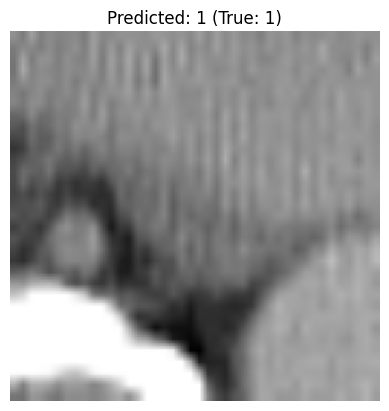

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7604 - loss: 0.7610
✅ Test Accuracy: 0.7500


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.73      0.80      0.76        10
           2       0.60      0.90      0.72        10
           3       1.00      0.40      0.57        10

    accuracy                           0.75        40
   macro avg       0.81      0.75      0.74        40
weighted avg       0.81      0.75      0.74        40



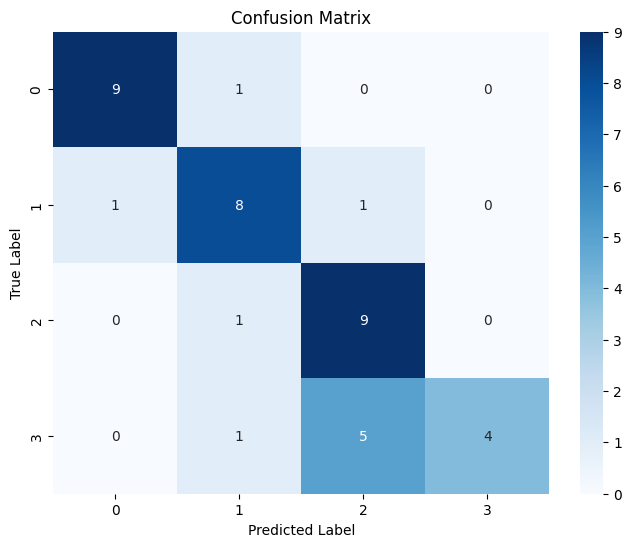

In [20]:
# 📦 Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"
model_save_path = os.path.join(dataset_path, "nsclc_mobilenetv3_model_final.keras")  # save/load as .keras

# ------------------------
# 2. LOAD SPLIT DATA
# ------------------------

X_train = np.load(os.path.join(dataset_path, 'X_train.npy'))
X_val = np.load(os.path.join(dataset_path, 'X_val.npy'))
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))

y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

clinical_train = np.load(os.path.join(dataset_path, 'clinical_train.npy'))
clinical_val = np.load(os.path.join(dataset_path, 'clinical_val.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))

print(f"✅ Loaded data shapes:")
print(f"Train: {X_train.shape}, Clinical: {clinical_train.shape}")
print(f"Val: {X_val.shape}, Clinical: {clinical_val.shape}")
print(f"Test: {X_test.shape}, Clinical: {clinical_test.shape}")

# ------------------------
# 3. CLASS WEIGHTS
# ------------------------

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: {class_weights}")

# ------------------------
# 4. BUILD MODEL (MobileNetV3Small + Clinical)
# ------------------------

def build_mobilenetv3_multi_input(img_shape=(128,128,2), clinical_shape=(6,), num_classes=4):
    from tensorflow.keras.applications import MobileNetV3Small
    from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, concatenate, BatchNormalization, Conv2D, Resizing

    img_input = Input(shape=img_shape)

    # Convert (128,128,2) -> (128,128,3)
    if img_shape[-1] == 2:
        x = Conv2D(3, (1,1), padding='same')(img_input)
    else:
        x = img_input

    # Resize manually
    x = Resizing(224, 224)(x)

    # MobileNetV3Small
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base_model.trainable = False  # Freeze

    features = base_model(x)
    features = GlobalAveragePooling2D()(features)
    features = Dense(256, activation='relu')(features)
    features = Dropout(0.4)(features)

    # Clinical branch
    clin_input = Input(shape=clinical_shape)
    clinical_features = Dense(64, activation='relu')(clin_input)
    clinical_features = BatchNormalization()(clinical_features)
    clinical_features = Dropout(0.4)(clinical_features)

    # Merge
    combined = concatenate([features, clinical_features])

    z = Dense(128, activation='relu')(combined)
    z = Dropout(0.5)(z)
    output = Dense(num_classes, activation='softmax')(z)

    model = tf.keras.Model(inputs=[img_input, clin_input], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_mobilenetv3_multi_input()
model.summary()

# ------------------------
# 5. TRAIN
# ------------------------

history = model.fit(
    [X_train, clinical_train], y_train,
    validation_data=([X_val, clinical_val], y_val),
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    ]
)

# ------------------------
# 6. SAVE MODEL
# ------------------------

model.save(model_save_path)
print(f"✅ Model saved to {model_save_path}")

# ------------------------
# 7. LOAD MODEL
# ------------------------

model = tf.keras.models.load_model(model_save_path)
print("✅ Model loaded from .keras file!")

# ------------------------
# 8. PREDICT ONE SAMPLE
# ------------------------

random_idx = np.random.randint(0, len(X_test))
sample_img = X_test[random_idx]
sample_clinical = clinical_test[random_idx]
true_label = y_test[random_idx]

sample_img_expanded = np.expand_dims(sample_img, axis=0)
sample_clinical_expanded = np.expand_dims(sample_clinical, axis=0)

prediction = model.predict([sample_img_expanded, sample_clinical_expanded])
predicted_class = np.argmax(prediction)

print("\n🎯 Prediction Results:")
print(f"True Cancer Stage: {true_label}")
print(f"Predicted Cancer Stage: {predicted_class}")
print(f"Prediction Probabilities: {prediction.flatten()}")

# Plot image
plt.imshow(sample_img[:,:,0], cmap='gray')
plt.title(f"Predicted: {predicted_class} (True: {true_label})")
plt.axis('off')
plt.show()

# ------------------------
# 9. EVALUATE FULL TEST SET
# ------------------------

# Evaluate on whole test set
loss, acc = model.evaluate([X_test, clinical_test], y_test, verbose=1)
print(f"✅ Test Accuracy: {acc:.4f}")

# Confusion matrix and classification report
y_pred_probs = model.predict([X_test, clinical_test])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


✅ Model loaded!
✅ Loaded test set: (40, 128, 128, 2) images and (40, 6) clinical features
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 984ms/step

🎯 Prediction Results:
True Cancer Stage: 2
Predicted Cancer Stage: 2
Prediction Probabilities: [0.04915768 0.26489744 0.3917521  0.29419273]


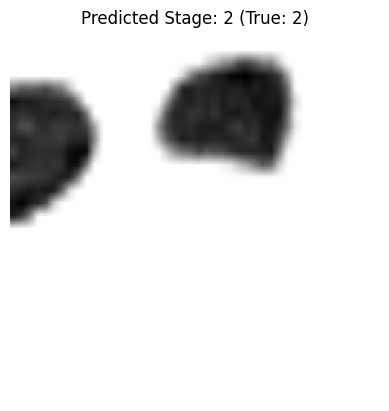

In [21]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"  # Your dataset
model_path = os.path.join(dataset_path, "nsclc_mobilenetv3_model_final.keras")  # Correct clean path!

# ------------------------
# 2. LOAD MODEL
# ------------------------

model = tf.keras.models.load_model(model_path)
print("✅ Model loaded!")

# ------------------------
# 3. LOAD TEST DATA
# ------------------------

X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

print(f"✅ Loaded test set: {X_test.shape} images and {clinical_test.shape} clinical features")

# ------------------------
# 4. SELECT ONE RANDOM TEST SAMPLE
# ------------------------

random_idx = np.random.randint(0, len(X_test))
sample_img = X_test[random_idx]
sample_clinical = clinical_test[random_idx]
true_label = y_test[random_idx]

# Expand dims to match model input
sample_img_expanded = np.expand_dims(sample_img, axis=0)
sample_clinical_expanded = np.expand_dims(sample_clinical, axis=0)

# ------------------------
# 5. PREDICT
# ------------------------

prediction = model.predict([sample_img_expanded, sample_clinical_expanded])
predicted_class = np.argmax(prediction)

print("\n🎯 Prediction Results:")
print(f"True Cancer Stage: {true_label}")
print(f"Predicted Cancer Stage: {predicted_class}")
print(f"Prediction Probabilities: {prediction.flatten()}")

# ------------------------
# 6. SHOW IMAGE
# ------------------------

plt.imshow(sample_img[:, :, 0], cmap='gray')
plt.title(f"Predicted Stage: {predicted_class} (True: {true_label})")
plt.axis('off')
plt.show()


✅ All models loaded!
✅ Custom CNN -> Accuracy: 0.8000, Loss: 0.5450
✅ EfficientNetV2B0 -> Accuracy: 0.8500, Loss: 0.4162
✅ VGG-Style CNN -> Accuracy: 0.9250, Loss: 0.1785


✅ EfficientNetB0 -> Accuracy: 0.7000, Loss: 0.8621


✅ MobileNetV3Small -> Accuracy: 0.7500, Loss: 0.7661


C:\Users\ROYAUME MEDIAS\AppData\Local\Temp\ipykernel_2256\2158260008.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette="Blues_d")
C:\Users\ROYAUME MEDIAS\AppData\Local\Temp\ipykernel_2256\2158260008.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=losses, palette="Reds_d")


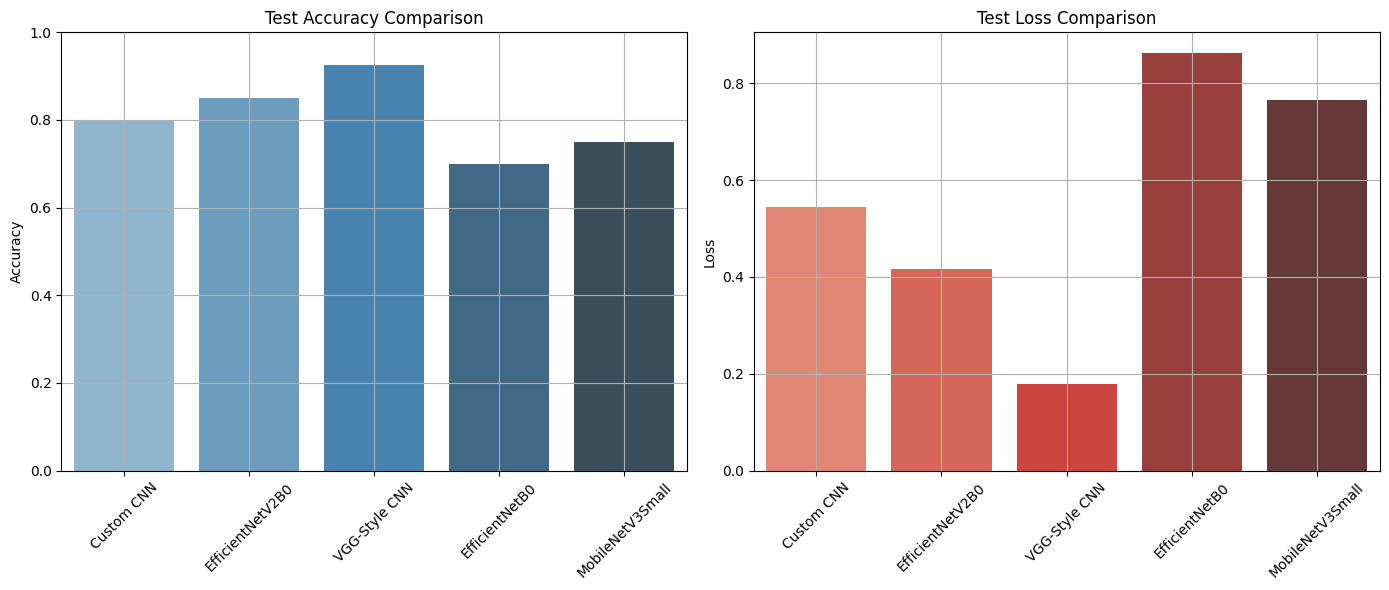

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step


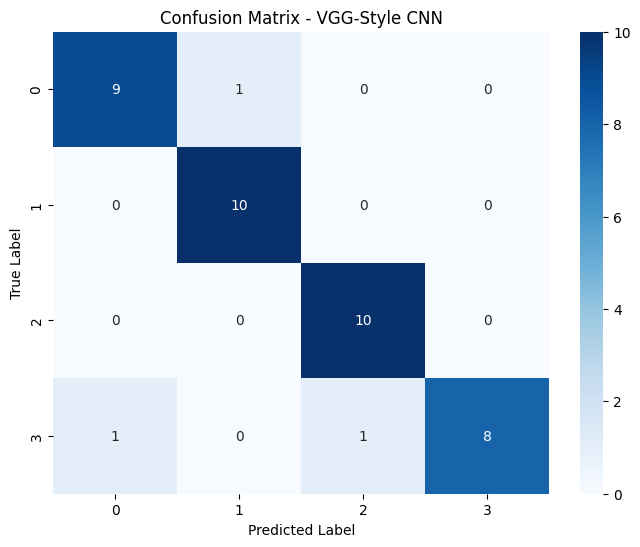


📊 Classification Report for Best Model (VGG-Style CNN):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.91      1.00      0.95        10
           2       0.91      1.00      0.95        10
           3       1.00      0.80      0.89        10

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40



In [26]:
# 📦 Imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ------------------------
# 1. CONFIG
# ------------------------

dataset_path = r"E:\NSCLC_final_dataset"

# Load test data
X_test = np.load(os.path.join(dataset_path, 'X_test.npy'))
clinical_test = np.load(os.path.join(dataset_path, 'clinical_test.npy'))
y_test = np.load(os.path.join(dataset_path, 'y_test.npy'))

# ------------------------
# 2. LOAD ALL MODELS
# ------------------------

models = {
    "Custom CNN": tf.keras.models.load_model(os.path.join(dataset_path, "nsclc_model_final.h5")),
    "EfficientNetV2B0": tf.keras.models.load_model(os.path.join(dataset_path, "nsclc_efficientnetv2b0_model_final.keras")),
    "VGG-Style CNN": tf.keras.models.load_model(os.path.join(dataset_path, "nsclc_vgg_model_final.h5")),
    "EfficientNetB0": tf.keras.models.load_model(os.path.join(dataset_path, "nsclc_efficientnet_model_final.h5")),
    "MobileNetV3Small": tf.keras.models.load_model(os.path.join(dataset_path, "nsclc_mobilenetv3_model_final.keras")),
}

print("✅ All models loaded!")

# ------------------------
# 3. EVALUATE ALL MODELS
# ------------------------

results = {}

for name, model in models.items():
    loss, acc = model.evaluate([X_test, clinical_test], y_test, verbose=0)
    results[name] = {"accuracy": acc, "loss": loss}
    print(f"✅ {name} -> Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# ------------------------
# 4. PLOT COMPARISON
# ------------------------

# Prepare data
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]
losses = [results[m]["loss"] for m in model_names]

# Plot
plt.figure(figsize=(14,6))

# Accuracy Bar Plot
plt.subplot(1,2,1)
sns.barplot(x=model_names, y=accuracies, palette="Blues_d")
plt.title('Test Accuracy Comparison')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Bar Plot
plt.subplot(1,2,2)
sns.barplot(x=model_names, y=losses, palette="Reds_d")
plt.title('Test Loss Comparison')
plt.xticks(rotation=45)
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

# ------------------------
# 5. CONFUSION MATRIX + REPORT FOR BEST MODEL
# ------------------------

# Find best model by highest accuracy
best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_model = models[best_model_name]

# Predict
y_pred_probs = best_model.predict([X_test, clinical_test])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# Classification report
print(f"\n📊 Classification Report for Best Model ({best_model_name}):")
print(classification_report(y_test, y_pred_classes))


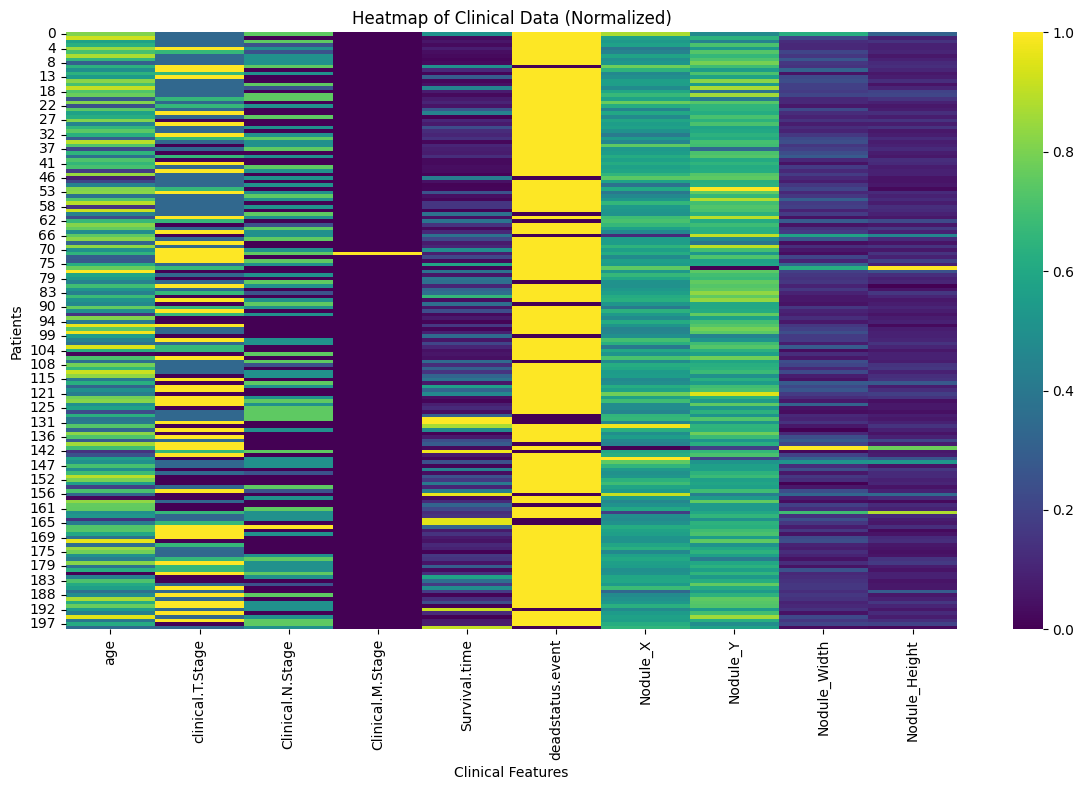

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load CSV
csv_path = r"D:\NSCLC-Radiomics-Lung1.clinical-version3-Oct-2019.csv"
df = pd.read_csv(csv_path)

# Select only numeric columns (for heatmap)
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Optional: drop rows with missing values
numeric_df = numeric_df.dropna()

# Normalize values for better visualization (optional)
normalized_df = (numeric_df - numeric_df.min()) / (numeric_df.max() - numeric_df.min())

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_df, cmap="viridis", cbar=True)
plt.title("Heatmap of Clinical Data (Normalized)")
plt.xlabel("Clinical Features")
plt.ylabel("Patients")
plt.tight_layout()
plt.show()